# Fasttext Standard Classifier

## Abstract
<ul>
    <li><b>Input</b>: Preprocessed data</li>
    <li><b>Process</b>: Using the standard classifier from fasttext to get results. Automatic holdout tuning.</li> 
    <li><b>Output</b>: Results. Evaluated with holdout</li>
    <li><b>Sources</b>: Mostly https://fasttext.cc/docs/en/supervised-tutorial.html and https://towardsdatascience.com/fasttext-sentiment-analysis-for-tweets-a-straightforward-guide-9a8c070449a2 and https://www.cognitivecoder.com/2018/03/29/3-quick-ways-to-create-graphs-of-your-class-distributions-in-python/ and https://gist.github.com/loretoparisi/41b918add11893d761d0ec12a3a4e1aa</li>
</ul>

In [3]:
import fasttext
import pandas as pd
from ast import literal_eval
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Use the line below to show inline in a notebook
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
dict = {
    "token": True,  #mandatory True
    "token_sentenceSeperate":False,
    "token_includePunctation":False,
    "token_excludeSpecPuct" :[],
    "remStpwrds": False,
    "stemm": True,
    "lemmatize": False,
    "nGram": False,
    "nGram_length":2
}

df = pd.read_csv("../data/preprocessed/"+"_".join(str(key) + str(value) for key, value in dict.items())+".csv")
df = df[['Review', 'Reviewer_Score']]

515738


[94439 94439 94439]
[44097 20237 13027]
[44096 20237 13028]


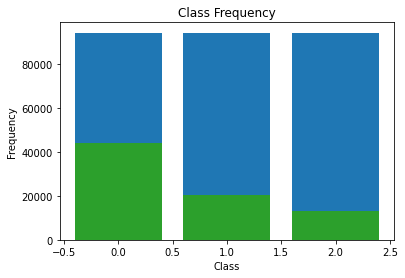

[205781  94439  60796]
[44096 20237 13028]
[44097 20237 13027]


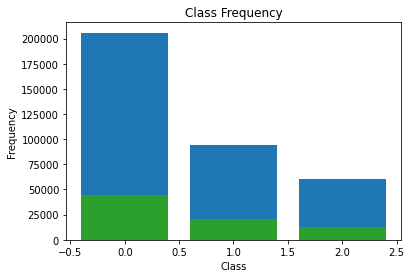

In [3]:
def train_test_valid_split(df,upsampling=True):
    train,test = train_test_split(df,test_size=0.3,stratify=df["Reviewer_Score"])
    test,valid = train_test_split(test,test_size=0.5,stratify=test["Reviewer_Score"])
    

    unique, counts_train = np.unique(train["Reviewer_Score"], return_counts=True)
    if(upsampling):
        train_0 = train[train["Reviewer_Score"]==0].sample(frac=(counts_train[1]/counts_train[0]))
        train_1 = train[train["Reviewer_Score"]==1]
        train_2 = train[train["Reviewer_Score"]==2].sample(frac=(counts_train[1]/counts_train[2]),replace=True)
        train = train_0.append(train_1).append(train_2)
    unique, counts_train = np.unique(train["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts_train)
    print(counts_train)
    
    unique, counts = np.unique(test["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts)
    print(counts)
    
    unique, counts = np.unique(valid["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts)
    print(counts)

        

    plt.title('Class Frequency')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    plt.show()
    
    return train,valid,test

    
def prepare(df,save_path):    
    df_copy = df[['Review', 'Reviewer_Score']]
    df_copy["Review"] = df_copy["Review"].apply(lambda review: " ".join(literal_eval(review)))


    txt = ""

    for index,row in df_copy.iterrows():
        new_line = "__label__"+str(row["Reviewer_Score"])+" "+str(row["Review"])
        txt += "\n" + new_line

    text_file = open("../data/fasttextClassifier_"+save_path+".txt", "w")
    n = text_file.write(txt)
    text_file.close()

    
    
def prepare_datasets_for_fasttext(df,upsampling): 
    train,valid,test = train_test_valid_split(df,upsampling)
    
    up = "UP" if upsampling else ""
    
    prepare(train,"train"+up)
    prepare(valid,"valid"+up)
    prepare(test,"test"+up) 
    


    

prepare_datasets_for_fasttext(df,True)
prepare_datasets_for_fasttext(df,False)

#Explanation: Green is the distribution of holdout/test set. Blue is the distribution of the trainingsset

In [4]:
#hyper_params = {"lr": 0.05,
#    "epoch": 60,
#    "wordNgrams": 2,
#    "dim": 250}     

#we did only sample the training data, not any other data
model_sampled_training = fasttext.train_supervised(input="../data/fasttextClassifier_trainUP.txt", autotuneValidationFile="../data/fasttextClassifier_validUP.txt", autotuneDuration=7000)
model = fasttext.train_supervised(input="../data/fasttextClassifier_train.txt", autotuneValidationFile="../data/fasttextClassifier_valid.txt", autotuneDuration=7000)

In [5]:
# model.save_model("model.bin")
# model_sampled_training.save_model("model_UP.bin")

In [6]:
def print_results(N, p, r, model):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(0, p))
    print("R@{}\t{:.3f}".format(0, r))
    print(model.lr,model.epoch,model.wordNgrams,model.dim,model.loss,model.lrUpdateRate)

print_results(*model.test("../data/fasttextClassifier_test.txt"),model)
print_results(*model_sampled_training.test("../data/fasttextClassifier_test.txt"),model_sampled_training)

N	77361
P@0	0.686
R@0	0.686
0.3434409509983074 15 5 177 loss_name.softmax 100
N	77361
P@0	0.657
R@0	0.657
0.01 100 1 112 loss_name.softmax 100


We evaluate both variants here, this part is just for evaluating

# Unbalanced

In [4]:
from fasttext.FastText import load_model

model = load_model("model.bin")
model_sampled_training = load_model("model_UP.bin")

[[37228, 5606, 1262], [9383, 7615, 3239], [1422, 3367, 8239]]


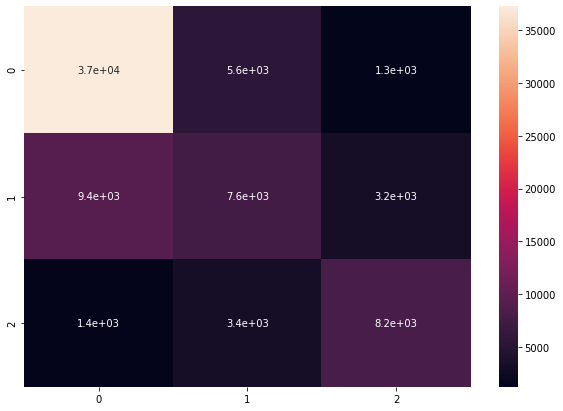

In [13]:
import re
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def trans(line):
    if line=="__label__0":
        return 0
    if line=="__label__1":
        return 1
    if line=="__label__2":
        return 2
    
    
predicted = []
correct = []
    
confusion_matrix = [[0,0,0],[0,0,0],[0,0,0]]
file = open("../data/fasttextClassifier_test.txt")
for a in file:
    label = re.findall("__label__\d*", a)
    if len(label)==0:
        continue
    line = re.sub("__label__\d*", "",a,1)
    line = re.sub("\n", "",line,1)
    predicted_label = model.predict(line)[0][0]
    
    
    confusion_matrix[trans(label[0])][trans(predicted_label)] = confusion_matrix[trans(label[0])][trans(predicted_label)]+1
    
    predicted.append(trans(predicted_label))
    correct.append(trans(label[0]))
    
print(confusion_matrix)




df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [14]:
print(correct[0:10])
print(predicted[0:10])
print(len(correct)/len(predicted))


[0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
1.0


In [15]:
from sklearn.metrics import classification_report

y_true = correct
y_pred = predicted
target_names = ['Positive', 'Neutral', 'Negative']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.78      0.84      0.81     44096
     Neutral       0.46      0.38      0.41     20237
    Negative       0.65      0.63      0.64     13028

    accuracy                           0.69     77361
   macro avg       0.63      0.62      0.62     77361
weighted avg       0.67      0.69      0.68     77361



# Balanced

[[31260, 9901, 2935], [5202, 9994, 5041], [585, 2879, 9564]]


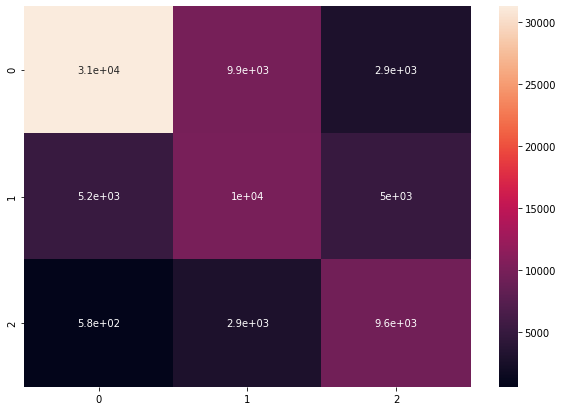

In [17]:
import re
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def trans(line):
    if line=="__label__0":
        return 0
    if line=="__label__1":
        return 1
    if line=="__label__2":
        return 2
    
    
predicted = []
correct = []
    
confusion_matrix = [[0,0,0],[0,0,0],[0,0,0]]
file = open("../data/fasttextClassifier_test.txt")
for a in file:
    label = re.findall("__label__\d*", a)
    if len(label)==0:
        continue
    line = re.sub("__label__\d*", "",a,1)
    line = re.sub("\n", "",line,1)
    predicted_label = model_sampled_training.predict(line)[0][0]
    

    confusion_matrix[trans(label[0])][trans(predicted_label)] = confusion_matrix[trans(label[0])][trans(predicted_label)]+1
    
    predicted.append(trans(predicted_label))
    correct.append(trans(label[0]))
    
print(confusion_matrix)




df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [18]:
from sklearn.metrics import classification_report

y_true = correct
y_pred = predicted
target_names = ['Positive', 'Neutral', 'Negative']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.84      0.71      0.77     44096
     Neutral       0.44      0.49      0.46     20237
    Negative       0.55      0.73      0.63     13028

    accuracy                           0.66     77361
   macro avg       0.61      0.65      0.62     77361
weighted avg       0.69      0.66      0.67     77361



Try some predicitions for yourself. You may have to load the model

In [6]:
print(model.predict("Poor Management. Very bad pool"))
print(model.predict("I love this hotel everything is so awesome i like it"))
print(model.predict("pool was ok everything was fine but i didnt like the waitress"))

(('__label__2',), array([0.48021793]))
(('__label__0',), array([0.99087995]))
(('__label__0',), array([0.72167194]))


Same thing again, but without stopwords

# With stopword removal

In [4]:
dict = {
    "token": True,  #mandatory True
    "token_sentenceSeperate":False,
    "token_includePunctation":False,
    "token_excludeSpecPuct" :[],
    "remStpwrds": True,
    "stemm": True,
    "lemmatize": False,
    "nGram": False,
    "nGram_length":2
}

df = pd.read_csv("../data/preprocessed/"+"_".join(str(key) + str(value) for key, value in dict.items())+".csv")
df = df[['Review', 'Reviewer_Score']]

[94439 94439 94439]
[44096 20237 13028]
[44097 20237 13027]


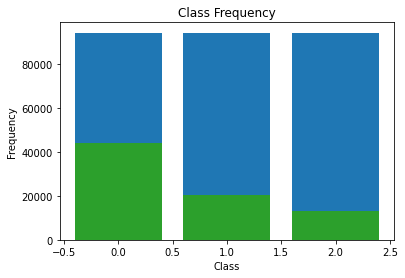

[205781  94439  60796]
[44096 20237 13028]
[44097 20237 13027]


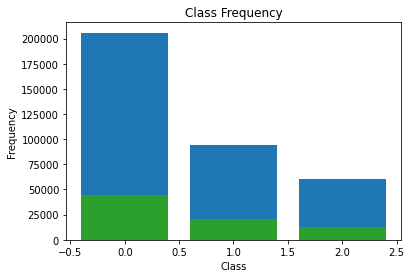

In [5]:
def train_test_valid_split(df,upsampling=True):
    train,test = train_test_split(df,test_size=0.3,stratify=df["Reviewer_Score"])
    test,valid = train_test_split(test,test_size=0.5,stratify=test["Reviewer_Score"])
    

    unique, counts_train = np.unique(train["Reviewer_Score"], return_counts=True)
    if(upsampling):
        train_0 = train[train["Reviewer_Score"]==0].sample(frac=(counts_train[1]/counts_train[0]))
        train_1 = train[train["Reviewer_Score"]==1]
        train_2 = train[train["Reviewer_Score"]==2].sample(frac=(counts_train[1]/counts_train[2]),replace=True)
        train = train_0.append(train_1).append(train_2)
    unique, counts_train = np.unique(train["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts_train)
    print(counts_train)
    
    unique, counts = np.unique(test["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts)
    print(counts)
    
    unique, counts = np.unique(valid["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts)
    print(counts)

        

    plt.title('Class Frequency')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    plt.show()
    
    return train,valid,test

    
def prepare(df,save_path):    
    df_copy = df[['Review', 'Reviewer_Score']]
    df_copy["Review"] = df_copy["Review"].apply(lambda review: " ".join(literal_eval(review)))


    txt = ""

    for index,row in df_copy.iterrows():
        new_line = "__label__"+str(row["Reviewer_Score"])+" "+str(row["Review"])
        txt += "\n" + new_line

    text_file = open("../data/fasttextClassifier_"+save_path+".txt", "w")
    n = text_file.write(txt)
    text_file.close()

    
    
def prepare_datasets_for_fasttext(df,upsampling): 
    train,valid,test = train_test_valid_split(df,upsampling)
    
    up = "UP" if upsampling else ""
    
    prepare(train,"train"+up)
    prepare(valid,"valid"+up)
    prepare(test,"test"+up) 
    


    

prepare_datasets_for_fasttext(df,True)
prepare_datasets_for_fasttext(df,False)

In [6]:
#hyper_params = {"lr": 0.05,
#    "epoch": 60,
#    "wordNgrams": 2,
#    "dim": 250}     

#we did only sample the training data, not any other data
model_sampled_training = fasttext.train_supervised(input="../data/fasttextClassifier_trainUP.txt", autotuneValidationFile="../data/fasttextClassifier_validUP.txt", autotuneDuration=7000)
model_sampled_training.save_model("model_UPstp.bin")

In [7]:
model = fasttext.train_supervised(input="../data/fasttextClassifier_train.txt", autotuneValidationFile="../data/fasttextClassifier_valid.txt", autotuneDuration=7000)
model.save_model("modelstp.bin")

In [8]:
def print_results(N, p, r, model):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(0, p))
    print("R@{}\t{:.3f}".format(0, r))
    print(model.lr,model.epoch,model.wordNgrams,model.dim,model.loss,model.lrUpdateRate)

print_results(*model.test("../data/fasttextClassifier_test.txt"),model)
print_results(*model_sampled_training.test("../data/fasttextClassifier_test.txt"),model_sampled_training)

N	77361
P@0	0.683
R@0	0.683
0.1763732221266724 3 4 179 loss_name.softmax 100
N	77361
P@0	0.659
R@0	0.659
0.3007315883150453 1 1 155 loss_name.softmax 100


We evaluate both variants here, this part is just for evaluating

# Unbalanced

In [9]:
from fasttext.FastText import load_model

model = load_model("modelstp.bin")
model_sampled_training = load_model("model_UPstp.bin")

[[39300, 3488, 1308], [11401, 5723, 3113], [2394, 2807, 7827]]


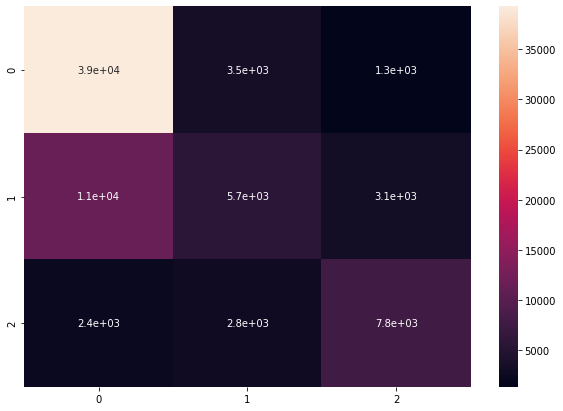

In [10]:
import re
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def trans(line):
    if line=="__label__0":
        return 0
    if line=="__label__1":
        return 1
    if line=="__label__2":
        return 2
    
    
predicted = []
correct = []
    
confusion_matrix = [[0,0,0],[0,0,0],[0,0,0]]
file = open("../data/fasttextClassifier_test.txt")
for a in file:
    label = re.findall("__label__\d*", a)
    if len(label)==0:
        continue
    line = re.sub("__label__\d*", "",a,1)
    line = re.sub("\n", "",line,1)
    predicted_label = model.predict(line)[0][0]
    
    
    confusion_matrix[trans(label[0])][trans(predicted_label)] = confusion_matrix[trans(label[0])][trans(predicted_label)]+1
    
    predicted.append(trans(predicted_label))
    correct.append(trans(label[0]))
    
print(confusion_matrix)




df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
print(correct[0:10])
print(predicted[0:10])
print(len(correct)/len(predicted))


In [11]:
from sklearn.metrics import classification_report

y_true = correct
y_pred = predicted
target_names = ['Positive', 'Neutral', 'Negative']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.74      0.89      0.81     44096
     Neutral       0.48      0.28      0.35     20237
    Negative       0.64      0.60      0.62     13028

    accuracy                           0.68     77361
   macro avg       0.62      0.59      0.59     77361
weighted avg       0.65      0.68      0.66     77361



# Balanced

[[41961, 81, 2054], [15524, 230, 4483], [4071, 132, 8825]]


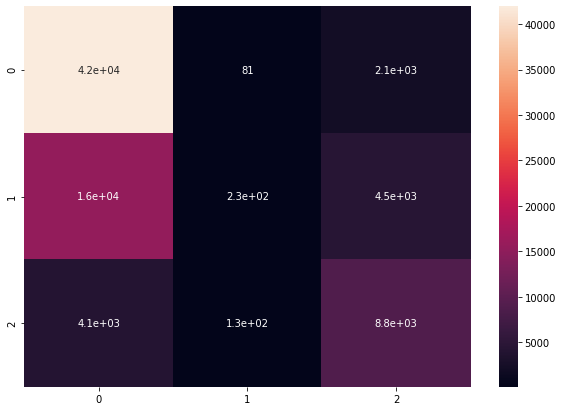

In [12]:
import re
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def trans(line):
    if line=="__label__0":
        return 0
    if line=="__label__1":
        return 1
    if line=="__label__2":
        return 2
    
    
predicted = []
correct = []
    
confusion_matrix = [[0,0,0],[0,0,0],[0,0,0]]
file = open("../data/fasttextClassifier_test.txt")
for a in file:
    label = re.findall("__label__\d*", a)
    if len(label)==0:
        continue
    line = re.sub("__label__\d*", "",a,1)
    line = re.sub("\n", "",line,1)
    predicted_label = model_sampled_training.predict(line)[0][0]
    

    confusion_matrix[trans(label[0])][trans(predicted_label)] = confusion_matrix[trans(label[0])][trans(predicted_label)]+1
    
    predicted.append(trans(predicted_label))
    correct.append(trans(label[0]))
    
print(confusion_matrix)




df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [13]:
from sklearn.metrics import classification_report

y_true = correct
y_pred = predicted
target_names = ['Positive', 'Neutral', 'Negative']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.68      0.95      0.79     44096
     Neutral       0.52      0.01      0.02     20237
    Negative       0.57      0.68      0.62     13028

    accuracy                           0.66     77361
   macro avg       0.59      0.55      0.48     77361
weighted avg       0.62      0.66      0.56     77361

